In [198]:
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [199]:
names = open('names.txt','r').read().splitlines()
chars = sorted(list(set((''.join(names)))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}
vocab_size = len(stoi)

In [200]:
def train_dev_test_data(names, context_len=3, n=None):
    X, y = [], []
    for name in names[:n]:
        context = [0] * context_len
        for char in name + '.':
            i = stoi[char]
            X.append(context)
            y.append(i)
            if n is not None and n < 10:
                print(''.join(itos[j] for j in context), '->', itos[i])
            context = context[1:] + [i]
    
    zipped = list(zip(X, y))
    random.shuffle(zipped)
    X, y = zip(*zipped)
    
    n_dev = int(0.8 * len(X))
    n_test = int(0.9 * len(X))
    
    X_train = torch.tensor(X[:n_dev])
    y_train = torch.tensor(y[:n_dev])
    
    X_dev = torch.tensor(X[n_dev:n_test])
    y_dev = torch.tensor(y[n_dev:n_test])
    
    X_test = torch.tensor(X[n_test:])
    y_test = torch.tensor(y[n_test:])
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [201]:
# hyperparameters
dim_embed = 10
context_len = 3
n_hid = 200
softmax_scale = 0.01 # ensure logit layer feeding forward into softmax gives uniform distribution output
kaiming_init = (5 / 3) / ((dim_embed * context_len) ** 0.5) # gain to modify activation std and reduce tanh saturation
M = 0.001

# data and parameters
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_data(names, context_len=context_len)
C = torch.randn(vocab_size, dim_embed)
W1 = torch.randn(dim_embed * context_len, n_hid) #* kaiming_init
b1 = torch.zeros(n_hid)
W2 = torch.randn(n_hid, vocab_size) * softmax_scale
b2 = torch.zeros(vocab_size)
gamma = torch.ones(1, n_hid)
beta = torch.zeros(1, n_hid)
mean_running = torch.zeros(1, n_hid)
std_running = torch.ones(1, n_hid)
params = [C, W1, b1, W2, b2, gamma, beta]

for p in params:
    p.requires_grad = True

# buffers for diagnostic plotting
lossi = []

      0/ 200000: 3.2720
  10000/ 200000: 2.4423
  20000/ 200000: 2.4145
  30000/ 200000: 2.0928
  40000/ 200000: 2.2899
  50000/ 200000: 2.3386
  60000/ 200000: 2.4306
  70000/ 200000: 2.3169
  80000/ 200000: 2.0019
  90000/ 200000: 2.2959
 100000/ 200000: 2.3132
 110000/ 200000: 1.9792
 120000/ 200000: 1.9024
 130000/ 200000: 2.1760
 140000/ 200000: 2.1947
 150000/ 200000: 2.0817
 160000/ 200000: 2.0992
 170000/ 200000: 2.4109
 180000/ 200000: 2.2470
 190000/ 200000: 2.1843


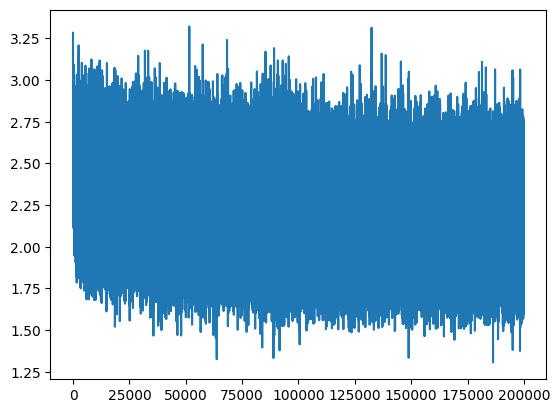

In [202]:
a = 0.1 # from plotting loss against different a and taking minimum
sz = 32
epochs = 200000

for e in range(epochs):
    # minibatch
    rows = torch.randint(0, X_train.shape[0], (sz, ))
    
    # forward pass
    emb = C[X_train[rows]].view(-1, dim_embed * context_len)
    lin = emb @ W1 + b1 # technically no need for bias if followed by BatchNorm layer because beta handles the biasing, computationally wasteful
    meani = lin.mean(0, keepdim=True)
    stdi = lin.std(0, keepdim=True)
    lin = gamma * (lin - meani) / stdi + beta
    act = torch.tanh(lin)
    logit = act @ W2 + b2
    loss = F.cross_entropy(logit, y_train[rows])

    with torch.no_grad():
        mean_running = (1-M) * mean_running + M * meani
        std_running  = (1-M) * std_running  + M * stdi
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # gradient descent
    for p in params:
        p.data -= a * p.grad if e < epochs / 2 else 0.1 * a * p.grad

    lossi.append(loss.item())

    if e % 10000 == 0:
        print(f'{e:7d}/{epochs:7d}: {loss.item():.4f}')
    #break
    
plt.plot(lossi);

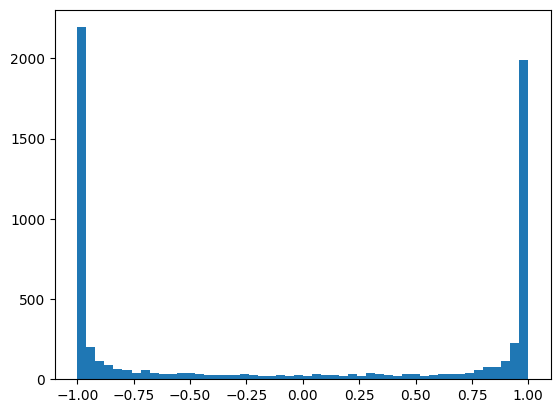

In [203]:
plt.hist(h.view(-1).tolist(), bins=50);

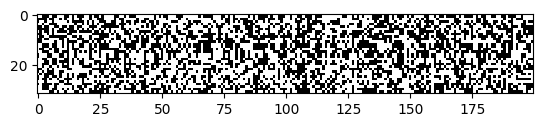

In [204]:
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [205]:
@torch.no_grad()
def compute_loss(split):
    X, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_dev)
    }[split]
    emb = C[X].view(-1, dim_embed * context_len)
    lin = emb @ W1 + b1
    lin = gamma * (lin - mean_running) / std_running + beta
    act = torch.tanh(lin)
    logit = act @ W2 + b2
    loss = F.cross_entropy(logit, y)
    return loss

print(f'Training loss: {compute_loss('train'):.4f}')
print(f'Dev loss: {compute_loss('dev'):.4f}')

Training loss: 2.1151
Dev loss: 2.1467


**Batch normalisation summary**

- Normalised with mean and std of each batch to make linear layer distributed ~ N(0,1) to improve activation disribution
- Due to normalisation, each input is now noisily influenced by whatever other random inputs came with (mean and std vary per batch), but this actually produces a regularisation effect
- People don't like this coupling which leads to weird results and bugs, so they try to avoid BatchNorm layers, but hard to because BatchNorm is effective
- Since the forward pass now involves a mean and std in the linear layer, we compute them on the side during training using a running sum with a momentum parameter for later use in inference

| Optimisation      | Training loss | Dev loss |
|-------------------|---------------|----------|
| Baseline          | 2.1165        | 2.1600   |
| Uniform softmax   | 2.0666        | 2.1329   |
| Unsaturated tanh  | 2.0428        | 2.1130   |


In [206]:
def make_name(k):
    g = torch.Generator().manual_seed(2147483647 + k)
    out = []
    context = [0] * context_len
    while True:
        emb = C[torch.tensor([context])].view(-1, dim_embed * context_len)
        lin = emb @ W1 + b1
        lin = gamma * (lin - mean_running) / std_running + beta
        act = torch.tanh(lin)
        logit = act @ W2 + b2
        p = F.softmax(logit, dim=1)
        i = torch.multinomial(p, num_samples=1, generator=g).item()
        context = context[1:] + [i]
        out.append(i)
        if i == 0:
            break

    return ''.join([itos[i] for i in out])

for k in range(10):
    print(make_name(k))

junide.
camlainor.
lylinn.
alianney.
jhyla.
cari.
amine.
kylie.
reiva.
kelleentelis.


# Making the code like PyTorch

In [207]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # <- gain
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:

    def __init__(self, fan_in, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training == True
        self.gamma = torch.ones(1, fan_in)
        self.beta = torch.zeros(1, fan_in)
        self.running_mean = torch.zeros(1, fan_in)
        self.running_var = torch.ones(1, fan_in)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [278]:
# hyperparameters
dim_embed = 10
context_len = 3
n_hid = 100
softmax_scale = 0.01 # ensure softmax gives uniform distribution output
kaiming_init = (5 / 3) / ((dim_embed * context_len) ** 0.5) # gain to modify activation std and reduce tanh saturation
M = 0.001

# data and parameters
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_data(names, context_len=context_len)
C = torch.randn(vocab_size, dim_embed)
layers = [
    Linear(dim_embed * context_len, n_hid), Tanh(),
    Linear(                  n_hid, n_hid), Tanh(),
    Linear(                  n_hid, n_hid), Tanh(),
    Linear(                  n_hid, n_hid), Tanh(),
    Linear(                  n_hid, n_hid), Tanh(),
    Linear(                  n_hid, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # # ensure last layer -- logit layer -- feeding forward into softmax initially gives uniform distribution output to reduce loss
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

46497


      0/ 200000: 3.3031


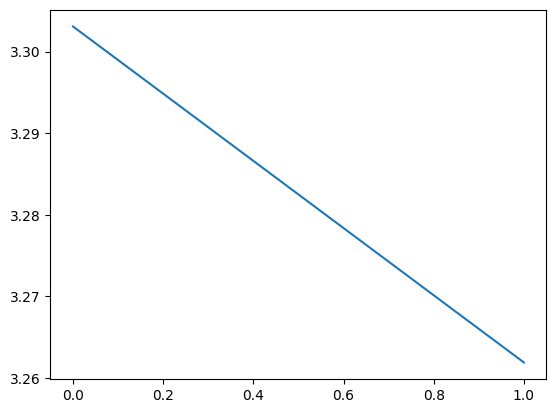

In [279]:
epochs = 200000
minibatch_sz = 32
lossi = []
updates = []
a = 0.1

for e in range(epochs):
    # minibatches
    rows = torch.randint(0, X_train.shape[0], (minibatch_sz, ))
    Xb, yb = X_train[rows], y_train[rows]

    # forward pass
    emb = C[Xb]
    x = emb.view(-1, dim_embed * context_len)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()

    # descent
    a = a if e < epochs / 2 else 0.1 * a
    for p in params:
        p.data -= a * p.grad

    lossi.append(loss.item())
    with torch.no_grad():
        if e < epochs / 2:
            updates.append([(a * p.grad.std() / p.data.std()).log10().item() for p in params])

    if e % 10000 == 0:
        print(f'{e:7d}/{epochs:7d}: {loss.item():.4f}')

    if e > 0:
        break

plt.plot(lossi);

## Statistics over activations, gradients and learning rates

layer 1 (   Tanh): mean -0.01, std 0.77, saturated: 22.53%
layer 3 (   Tanh): mean +0.03, std 0.70, saturated: 10.62%
layer 5 (   Tanh): mean +0.03, std 0.67, saturated: 6.34%
layer 7 (   Tanh): mean +0.02, std 0.65, saturated: 6.09%
layer 9 (   Tanh): mean +0.03, std 0.65, saturated: 5.97%


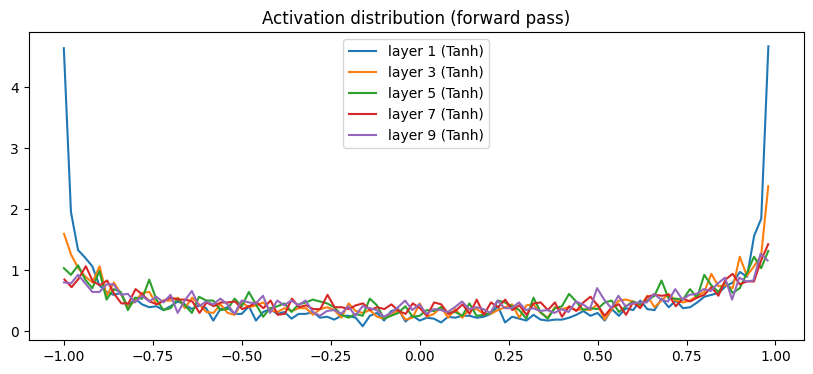

In [288]:
plt.figure(figsize=(10,4))
labels = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%7s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        labels.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(labels)
plt.title('Activation distribution (forward pass)');

layer 1 (   Tanh): mean -9.7e-06, std 4.8e-04
layer 3 (   Tanh): mean -2.3e-06, std 4.5e-04
layer 5 (   Tanh): mean -2.4e-05, std 4.2e-04
layer 7 (   Tanh): mean +6.0e-06, std 3.7e-04
layer 9 (   Tanh): mean -9.6e-06, std 3.2e-04


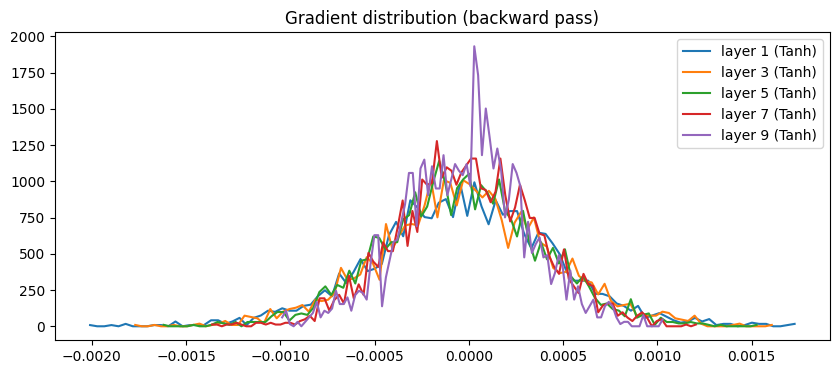

In [289]:
plt.figure(figsize=(10,4))
labels = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%7s): mean %+.1e, std %.1e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        labels.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(labels)
plt.title('Gradient distribution (backward pass)');

weight   (27, 10) | mean +2.0e-05 | std 1.6e-03 | grad:data ratio 1.6e-03
weight  (30, 100) | mean +4.4e-05 | std 1.6e-03 | grad:data ratio 5.3e-03
weight (100, 100) | mean -1.5e-05 | std 1.4e-03 | grad:data ratio 8.2e-03
weight (100, 100) | mean -1.3e-05 | std 1.2e-03 | grad:data ratio 7.2e-03
weight (100, 100) | mean +9.5e-06 | std 1.0e-03 | grad:data ratio 6.3e-03
weight (100, 100) | mean -6.5e-06 | std 8.6e-04 | grad:data ratio 5.1e-03
weight  (100, 27) | mean +5.5e-11 | std 2.4e-02 | grad:data ratio 2.2e+00


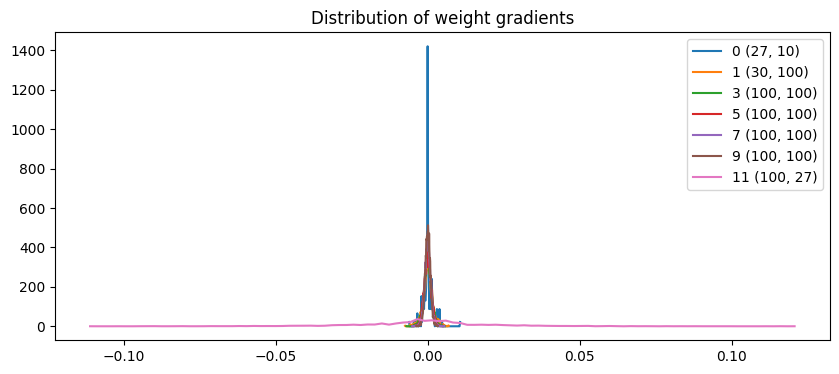

In [290]:
plt.figure(figsize=(10,4))
labels = []

for i, p in enumerate(params):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+.1e | std %.1e | grad:data ratio %.1e' % (tuple(t.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        labels.append(f'{i} {tuple(t.shape)}')
plt.legend(labels)
plt.title('Distribution of weight gradients');

Text(0.5, 1.0, 'Ratio of update size to weights')

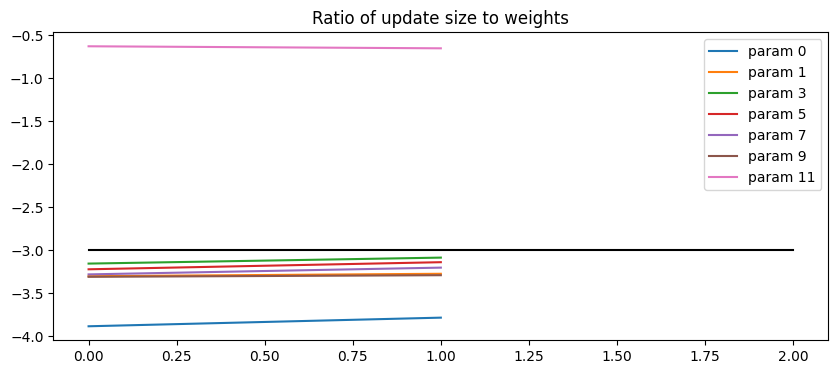

In [291]:
plt.figure(figsize=(10,4))
labels = []

for i, p in enumerate(params):
    t = p.grad
    if p.ndim == 2:
        plt.plot([updates[j][i] for j in range(len(updates))])
        labels.append(f'param {i}')
plt.plot([0, len(updates)], [-3, -3], color='black')
plt.legend(labels)
plt.title('Ratio of update size to weights');

**Using these statistics to diagnose network training**

- Gains are needed in linear layers (depending on `fan_in` and the subsequent activation function) to avoid neuron saturation and non-zero activations
- The gains should ensure that the distributions of the activations and gradients are not being squeezed/spread out as data flows through the network (i.e. `std` does not change too much)
- The weight gradient distribution tells us to look at the update size to the weights
- Over time, the ratio of the update size to the weights should be $10^{-3}$ so that the updates to the weights are not changing them too drastically
- Using batch normalisation will make the use of incorrect gains less punishing (by construction, as the inputs to the activation layers are normalised) but we might need to adjust the learning rate to get a better update size

In [276]:
def compute_loss_torch(split):
    X, y = {
        'train': (X_train, y_train),
        'dev': (X_dev, y_dev),
        'test': (X_test, y_dev)
    }[split]
    emb = C[X]
    x = emb.view(-1, dim_embed * context_len)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    return loss

print(f'Training loss: {compute_loss_torch('train'):.4f}')
print(f'Dev loss: {compute_loss_torch('dev'):.4f}')

Training loss: 2.0611
Dev loss: 2.1564


In [277]:
def make_name_torch(k):
    g = torch.Generator().manual_seed(2147483647 + k)
    out = []
    context = [0] * context_len
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(-1, dim_embed * context_len)
        for layer in layers:
            x = layer(x)
        p = F.softmax(x, dim=1)
        i = torch.multinomial(p, num_samples=1, generator=g).item()
        context = context[1:] + [i]
        out.append(i)
        if i == 0:
            break

    return ''.join([itos[i] for i in out])

for k in range(10):
    print(make_name_torch(k))

junide.
ayo.
xye.
alika.
jholph.
bari.
abdulmas.
kalye.
briah.
keleen.
